In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Load data
columns = ['q'+ str(i) for i in range(10)] + ['Age', 'Gender', 'Ethnicity', 'Born', 'Family', 'Who', 'Country', 'Used', 'Group','Screening', 'Score']
data=pd.read_csv('autism_data.arff', sep=',', header=None)
data.columns = columns
data = data.replace({'NO':0, 'YES':1})
data.head()

,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9,...,Gender,Ethnicity,Born,Family,Who,Country,Used,Group,Screening,Score
0,1,1,1,1,0,0,1,1,0,0,...,f,White-European,no,no,'United States',no,6,'18 and more',Self,0
1,1,1,0,1,0,0,0,1,0,1,...,m,Latino,no,yes,Brazil,no,5,'18 and more',Self,0
2,1,1,0,1,1,0,1,1,1,1,...,m,Latino,yes,yes,Spain,no,8,'18 and more',Parent,1
3,1,1,0,1,0,0,1,1,0,1,...,f,White-European,no,yes,'United States',no,6,'18 and more',Self,0
4,1,0,0,0,0,0,0,1,0,0,...,f,?,no,no,Egypt,no,2,'18 and more',?,0


In [36]:
# Create X and Y data
num_feat = 6
num_samples = 150
X = data.iloc[:num_samples,:num_feat]
Y = data.iloc[:num_samples,-1]
Z = data.iloc[:num_samples,[i for i in range(num_feat)] + [20]]
print(X.shape, Y.shape, Z.shape)

(150, 6) (150,) (150, 7)


In [37]:
# Map to probabilities
probs = []
for i in range(X.shape[0]):
    val = X.iloc[i]
    Z_sel = Z.query(" and ".join(["q" + str(k) +"==" + str(val[k]) for k in range(len(val))]))
    probs.append(Z_sel['Score'].mean())    
probs = np.array(probs)
print(np.unique(probs), probs.shape)

[0.         0.5        0.66666667 0.71428571 0.9        1.        ] (150,)


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
X_train, X_test, y_train, y_test = train_test_split( X.values, probs, test_size=0.15, random_state=42)

In [39]:
import pennylane as qml

nqbits = num_feat
dev_kernel = qml.device("default.qubit", wires=nqbits)

projector = np.zeros((2**nqbits, 2**nqbits))
projector[0, 0] = 1
    
@qml.qnode(dev_kernel, interface="autograd")
def kernel(x1, x2, weights):
    """The quantum kernel."""
    qml.templates.AngleEmbedding(x1, wires=range(nqbits))
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(nqbits))
    return qml.expval(qml.Hermitian(projector, wires=range(nqbits)))

def kernel_matrix(A, B):
    """Compute the matrix whose entries are the kernel
       evaluated on pairwise data from sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A])

In [55]:
from sklearn.svm import SVC, SVR

svm = SVR(kernel=kernel_matrix).fit(X_train, y_train)

TypeError: kernel_matrix() missing 1 required positional argument: 'weights'

In [41]:
from sklearn.metrics import accuracy_score
predictions = svm.predict(X_test)
predictions[predictions<0] = 0
predictions[predictions>1] = 1

In [42]:
np.mean(np.abs(predictions - y_test))

0.04579912152079927

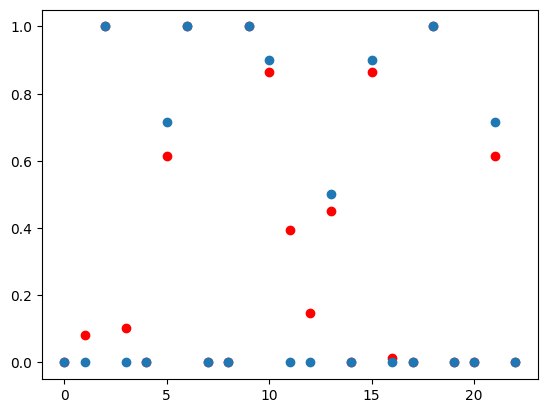

In [47]:
import matplotlib.pyplot as plt

plt.plot(predictions, 'o', color='red')
plt.plot(y_test, 'o')

In [48]:
predictions

array([0.        , 0.08040253, 1.        , 0.1023273 , 0.        ,
       0.61384016, 1.        , 0.        , 0.        , 1.        ,
       0.8654864 , 0.39308098, 0.1458494 , 0.45097462, 0.        ,
       0.8654864 , 0.01277589, 0.        , 1.        , 0.        ,
       0.        , 0.61384016, 0.        ])

In [49]:
y_test

array([0.        , 0.        , 1.        , 0.        , 0.        ,
       0.71428571, 1.        , 0.        , 0.        , 1.        ,
       0.9       , 0.        , 0.        , 0.5       , 0.        ,
       0.9       , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.71428571, 0.        ])

In [51]:
with open('predictions_SVR_6.npy', 'wb') as f:
    np.save(f,predictions)

with open('y_test_SVR_6.npy', 'wb') as f:
    np.save(f,y_test)